<a href="https://colab.research.google.com/github/HendricoYehezky/Tugas-3-Modern-Convolutional-Neural-Network/blob/main/9_2_Long_Short_Term_Memory_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade tensorflow

     |████████████████████████████████| 462 kB 7.6 MB/s 


In [1]:
!pip install d2l

In [2]:
import tensorflow as tf
from d2l import tensorflow as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [3]:
def get_lstm_params(vocab_size, num_hiddens):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return tf.Variable(tf.random.normal(shape=shape, stddev=0.01,
                                            mean=0, dtype=tf.float32))
    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                tf.Variable(tf.zeros(num_hiddens), dtype=tf.float32))

    W_xi, W_hi, b_i = three()  # Input gate parameters
    W_xf, W_hf, b_f = three()  # Forget gate parameters
    W_xo, W_ho, b_o = three()  # Output gate parameters
    W_xc, W_hc, b_c = three()  # Candidate memory cell parameters
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = tf.Variable(tf.zeros(num_outputs), dtype=tf.float32)
    # Attach gradients
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,
              b_c, W_hq, b_q]
    return params

In [4]:
def init_lstm_state(batch_size, num_hiddens):
    return (tf.zeros(shape=(batch_size, num_hiddens)),
            tf.zeros(shape=(batch_size, num_hiddens)))

In [5]:
def lstm(inputs, state, params):
    W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q = params
    (H, C) = state
    outputs = []
    for X in inputs:
        X=tf.reshape(X,[-1,W_xi.shape[0]])
        I = tf.sigmoid(tf.matmul(X, W_xi) + tf.matmul(H, W_hi) + b_i)
        F = tf.sigmoid(tf.matmul(X, W_xf) + tf.matmul(H, W_hf) + b_f)
        O = tf.sigmoid(tf.matmul(X, W_xo) + tf.matmul(H, W_ho) + b_o)
        C_tilda = tf.tanh(tf.matmul(X, W_xc) + tf.matmul(H, W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * tf.tanh(C)
        Y = tf.matmul(H, W_hq) + b_q
        outputs.append(Y)
    return tf.concat(outputs, axis=0), (H,C)

perplexity 1.1, 4882.4 tokens/sec on /GPU:0
time traveller cur fe said the viscery thi nour i meplacial to t
traveller coll se sath dimension which a cunile fren its af


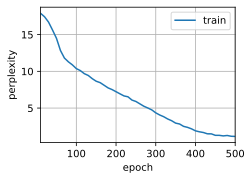

In [6]:
vocab_size, num_hiddens, device_name = len(vocab), 256, d2l.try_gpu()._device_name
num_epochs, lr = 500, 1
strategy = tf.distribute.OneDeviceStrategy(device_name)
with strategy.scope():
    model = d2l.RNNModelScratch(len(vocab), num_hiddens, init_lstm_state, lstm, get_lstm_params)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, strategy)

perplexity 1.0, 10593.3 tokens/sec on /GPU:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


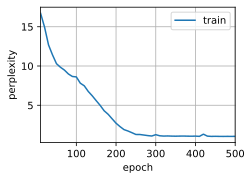

In [7]:
lstm_cell = tf.keras.layers.LSTMCell(num_hiddens,
    kernel_initializer='glorot_uniform')
lstm_layer = tf.keras.layers.RNN(lstm_cell, time_major=True,
    return_sequences=True, return_state=True)
device_name = d2l.try_gpu()._device_name
strategy = tf.distribute.OneDeviceStrategy(device_name)
with strategy.scope():
    model = d2l.RNNModel(lstm_layer, vocab_size=len(vocab))
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, strategy)